# Abstract

The goal of this project is modelling different scenarios and interventions to see to what extent individuals’ risk perception is affected, leading to a different set of behaviours with respect to COVID-19 preventions.
The idea is that if we were able to identify those latent factors which are more capable of driving human’s behaviours, we might be able to nudge individuals to behave more respectfully and carefully without imposing any legal restrictions. 


![title](Immagine1.png)

# Table of Contents

1. [Data Cleaning](#datacleaning)
    2. [Exploratory statistics](#stats)
2. [Classification algorithm](#classification)
3. [ABM models](#abm)
    1. [ABM complete](#abm_complete)
    2. [ABM with no intervention](#abm_noint)
    3. [ABM with community leaders](#abm_comm)
    4. [ABM with young sensibilization campaigns](#abm_young)


# Data cleaning <a name="datacleaning"></a> 

In this section I am going to pre-process data collected from my survey. I will map to binary all categorical variables and compure the dependent variable, the individual risk perception, as the average of 5 variables.

First of all, let's download all the necessary packages.

In [5]:
!pip install mesa #for ABM model

     |████████████████████████████████| 655kB 12.3MB/s eta 0:00:01
     |████████████████████████████████| 51kB 6.6MB/s 


In [15]:
#importing necessary packages
%time
import networkx as nx

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid
from mesa.batchrunner import BatchRunner

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import community
from importlib import reload
import networkx as nx
reload(community)


Wall time: 0 ns


<module 'community' from 'C:\\Users\\valen\\Anaconda3\\lib\\site-packages\\community\\__init__.py'>

In [16]:
#do not run this cell, you can jump direclty to the next one in order to get the cleane df

data = pd.read_excel('risk perception.xlsx').drop('Informazioni cronologiche', axis = 1)
data['Age'] = data['Age'].astype('int')

#creating the columns of risk score

scores = []
for i in range(len(data)):
    score = (data['My_actual_covid_risk'][i] + data['My_future_covid_risk'][i] + 
             data['Beloved_risk'][i] + data['Health_threat'][i] + data['Media_influence'][i])/5
    scores.append(score)
    
data['Score'] = scores

scores_bin = [0]*len(data)
for i in range(len(data)):
    if data['Score'][i]>2.5:
        scores_bin[i] = 'high'
    else:
        scores_bin[i] = 'low'
        
data['risk'] = scores_bin
data.head()

data = data.drop(['My_actual_covid_risk','My_future_covid_risk', 'Beloved_risk', 'Health_threat', 'Media_influence', 'Score' ], axis = 1)


#mapping binary valus to 1-0
to_binary = {'Yes': 1, 'No': 0}
gender_to_binary = {'Male': 1, 'Female': 0}
data['Gender'] = data['Gender'].map(gender_to_binary)
data['Disease'] = data['Disease'].map(to_binary)
data['Safety'] = data['Safety'].map(to_binary)
data['Beloved_sick'] = data['Beloved_sick'].map(to_binary)
data['Beloved_care'] = data['Beloved_care'].map(to_binary)
data['Economic_impact'] = data['Economic_impact'].map(to_binary)
data['Individual_risk'] = data['Individual_risk'].map(to_binary)
data['Exposed_environment'] = data['Exposed_environment'].map(to_binary)
data['Easily_influenced'] = data['Easily_influenced'].map(to_binary)
data['Hypocondriac'] = data['Hypocondriac'].map(to_binary)
#data

#storing data into pickle format
data.to_pickle('data.pkl')

In [17]:
#df = pd.read_pickle('df.pkl')

data = pd.read_pickle('data.pkl')
data.head()

,Age,Gender,Disease,Region,Safety,Current_mood,Beloved_sick,Economic_impact,Individual_risk,Exposed_environment,Easily_influenced,Feeling,Avg_contacts,Beloved_care,Hypocondriac,risk
0,22,1,0,Emilia Romagna,0,"Your local health institution (family doctor, ...",0,0,1,0,1,"None of the above, I'm fine overall",4,0,0,high
1,23,1,0,Emilia Romagna,0,"Your local health institution (family doctor, ...",0,0,0,0,1,Melancoly,4,0,0,low
2,86,0,1,Emilia Romagna,0,"Your local health institution (family doctor, ...",1,0,1,0,0,Fear,1,1,0,high
3,27,1,0,Emilia Romagna,1,"Your local health institution (family doctor, ...",0,0,0,0,1,Melancoly,3,1,0,high
4,45,1,0,Lazio,0,"Your local health institution (family doctor, ...",0,0,1,0,1,Sadness,5,1,0,high


# Exoloratory analysis <a name="stats"></a> 

Text(0.5, 1.0, 'Age distribution by gender')

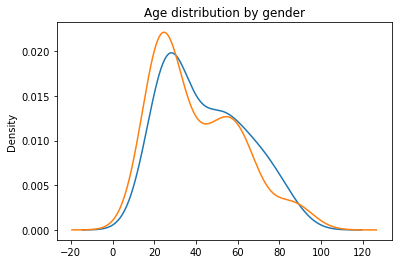

In [82]:
import matplotlib.pyplot as plt
data.groupby('Gender').Age.plot(kind='kde')
plt.title('Age distribution by gender')

The two genders seem to be balanced. Plus, there is a prevalence of interviewed aged between 20 and 30 years old, a range which in our research is targeted as "young".

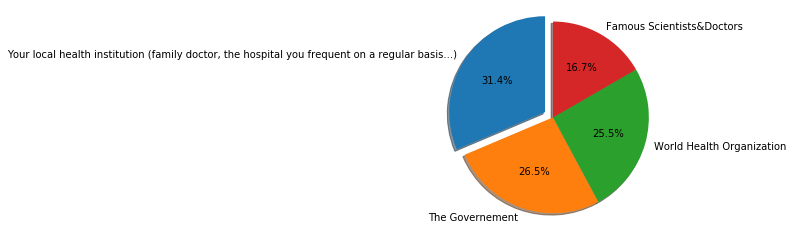

In [83]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = data.groupby('Current_mood')[['Age']].count().sort_values(by='Age',ascending=False).reset_index()['Current_mood'].values
sizes = data.groupby('Current_mood')[['Age']].count().sort_values(by='Age',ascending=False)['Age'].values #random column to count values
explode = (0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

The highest percentage of interviewed declared that they would trust more their local institution. This will be relevant while modeling interventions with communities.

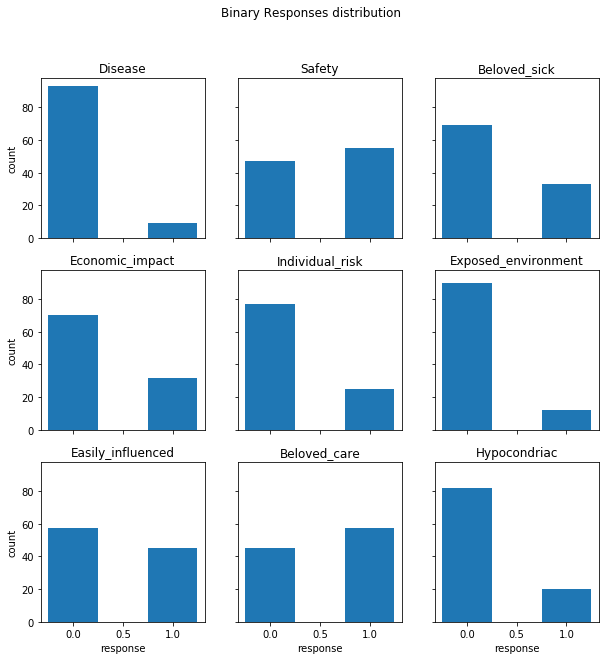

In [85]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharey=True,
                         sharex=True)
columns = ["Disease", "Safety", "Beloved_sick", "Economic_impact", "Individual_risk", "Exposed_environment", "Easily_influenced", "Beloved_care", "Hypocondriac"]
axs = axes.flatten()
fig.suptitle(r'Binary Responses distribution')
i = 0 

for col in columns:

    labels = data.groupby(col).count().reset_index()[col].values
    values = data.groupby(col).count().reset_index()['Age'].values #random count variable
            
    axs[i].bar(labels, values, width = 0.5)
    axs[i].set_title(str(col))
        
    labely = r'count'
    labelx = r'response' 


    if i in[0,3]:
        axs[i].set(xlabel= '', ylabel=labely)
    elif i in[7,8]:
        axs[i].set(xlabel= labelx, ylabel='')
    elif i in [6]:
        axs[i].set(xlabel= labelx, ylabel=labely)   
    else:
        axs[i].set(xlabel=' ', ylabel=' ')
    i +=1


Now I want to compute the dissimilarity matrix using the jaccard dissimilarity. Before doing that, I need to encode categorical variable to binary 1 and 0

In [86]:
data_binary = data[columns]
data_binary.head()

,Disease,Safety,Beloved_sick,Economic_impact,Individual_risk,Exposed_environment,Easily_influenced,Beloved_care,Hypocondriac
0,0,0,0,0,1,0,1,0,0
1,0,0,0,0,0,0,1,0,0
2,1,0,1,0,1,0,0,1,0
3,0,1,0,0,0,0,1,1,0
4,0,0,0,0,1,0,1,1,0


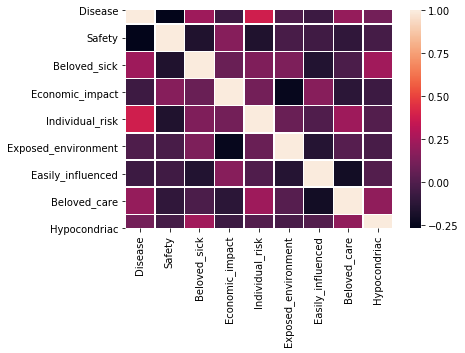

In [87]:
import seaborn as sns
ax = sns.heatmap(data_binary.corr(), linewidth=0.5)
plt.show()

In [88]:
data_binary.corr()

,Disease,Safety,Beloved_sick,Economic_impact,Individual_risk,Exposed_environment,Easily_influenced,Beloved_care,Hypocondriac
Disease,1.000000,-0.267177,0.228174,-0.061347,0.385239,-0.006311,-0.067566,0.206793,0.107544
Safety,-0.267177,1.000000,-0.159514,0.158748,-0.159141,-0.028728,-0.050097,-0.108350,-0.038854
Beloved_sick,0.228174,-0.159514,1.000000,0.074388,0.141860,0.137740,-0.150204,-0.018620,0.239077
Economic_impact,-0.061347,0.158748,0.074388,1.000000,0.105946,-0.246885,0.165207,-0.122653,-0.067826
Individual_risk,0.385239,-0.159141,0.141860,0.105946,1.000000,0.074903,-0.001350,0.230865,0.005628
Exposed_environment,-0.006311,-0.028728,0.137740,-0.246885,0.074903,1.000000,-0.140592,0.018025,-0.027050
Easily_influenced,-0.067566,-0.050097,-0.150204,0.165207,-0.001350,-0.140592,1.000000,-0.204678,0.008776
Beloved_care,0.206793,-0.108350,-0.018620,-0.122653,0.230865,0.018025,-0.204678,1.000000,0.190151
Hypocondriac,0.107544,-0.038854,0.239077,-0.067826,0.005628,-0.027050,0.008776,0.190151,1.000000


Finally, let's compute the average number of interaction for all the individuals, so that we will have our parameter K to build the network in our ABM.

In [19]:
data.Avg_contacts.mean()

4.421568627450981

# Classification Algorithm <a name="classification"></a> 

In [89]:
data = pd.read_pickle('data.pkl')
#not sure if I'll keep it....it would be easier for the abm model to drop them

one_hot = pd.get_dummies(data[['Current_mood', 'Feeling']])
df = data.join(one_hot)
df = df.drop(['Current_mood', 'Feeling', 'Region'], axis = 1)
df.head()

,Age,Gender,Disease,Safety,Beloved_sick,Economic_impact,Individual_risk,Exposed_environment,Easily_influenced,Avg_contacts,...,Current_mood_Famous Scientists&Doctors,Current_mood_The Governement,Current_mood_World Health Organization,"Current_mood_Your local health institution (family doctor, the hospital you frequent on a regular basis...)",Feeling_Anger,Feeling_Fear,Feeling_Lonely,Feeling_Melancoly,"Feeling_None of the above, I'm fine overall",Feeling_Sadness
0,22,1,0,0,0,0,1,0,1,4,...,0,0,0,1,0,0,0,0,1,0
1,23,1,0,0,0,0,0,0,1,4,...,0,0,0,1,0,0,0,1,0,0
2,86,0,1,0,1,0,1,0,0,1,...,0,0,0,1,0,1,0,0,0,0
3,27,1,0,1,0,0,0,0,1,3,...,0,0,0,1,0,0,0,1,0,0
4,45,1,0,0,0,0,1,0,1,5,...,0,0,0,1,0,0,0,0,0,1


In [90]:
df = data.drop(['Region', 'Current_mood', 'Feeling'], axis = 1)

In [91]:
risk_to_binary = {'high': 1, 'low': 0}
df['risk'] = df['risk'].map(risk_to_binary)
df

,Age,Gender,Disease,Safety,Beloved_sick,Economic_impact,Individual_risk,Exposed_environment,Easily_influenced,Avg_contacts,Beloved_care,Hypocondriac,risk
0,22,1,0,0,0,0,1,0,1,4,0,0,1
1,23,1,0,0,0,0,0,0,1,4,0,0,0
2,86,0,1,0,1,0,1,0,0,1,1,0,1
3,27,1,0,1,0,0,0,0,1,3,1,0,1
4,45,1,0,0,0,0,1,0,1,5,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,66,1,0,1,0,0,0,1,0,1,1,1,1
98,28,0,0,1,1,0,0,1,0,5,0,0,0
99,50,0,0,1,0,0,0,0,0,3,1,0,1
100,19,1,0,1,0,0,0,0,1,2,0,0,0


In [3]:
#storing results 
#df.to_pickle('df.pkl')

#downloading results
df = pd.read_pickle('df.pkl')

I only have 102 observations, not enough to train my algorithm. Hence, I decided to employ data augmentation technique. To do so, I defined a function which add new observations following the path of the real one, yet adding a flavour of randomness.

In [8]:
import random

def data_augmentation(df, n_times = 2):
    new_df=df.copy()
    for i in range(n_times-1):
        new_df = new_df.append(new_df).reset_index(drop=True)
    augmented_data = new_df.tail(len(new_df)-len(df)).reset_index(drop=True)
    r = np.random.randint(len(augmented_data),size=int(len(augmented_data)*0.5))
    c = random.choices(augmented_data.columns, k=int(len(augmented_data.columns)*0.5))
    for row in list(r):
        for col in c:
            augmented_data.at[row, col] = random.choice(augmented_data[col])
    return df.append(augmented_data)
            
    

    
#aug_df = data_augmentation(df, n_times = 5)
#len(aug_df)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

X = df.drop(['risk'], axis = 1)
Y = df['risk']

X_train, X_val, Y_train, Y_val = train_test_split(X, Y,  
    test_size=0.2, random_state=123)

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
val_scores = []

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, Y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, Y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_val, Y_val)))
    val_scores.append(gb_clf.score(X_val, Y_val))



Learning rate:  0.05
Accuracy score (training): 0.691
Accuracy score (validation): 0.619
Learning rate:  0.075
Accuracy score (training): 0.716
Accuracy score (validation): 0.667
Learning rate:  0.1
Accuracy score (training): 0.741
Accuracy score (validation): 0.667
Learning rate:  0.25
Accuracy score (training): 0.827
Accuracy score (validation): 0.571
Learning rate:  0.5
Accuracy score (training): 0.901
Accuracy score (validation): 0.667
Learning rate:  0.75
Accuracy score (training): 0.975
Accuracy score (validation): 0.667
Learning rate:  1
Accuracy score (training): 0.951
Accuracy score (validation): 0.762


In [5]:
#so we use a learning rate = 0.5 and train the corresponding model on the entire dataset
lr = lr_list[np.argmax(val_scores)]
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=lr, max_features=2, max_depth=2, random_state=123)
gb_clf.fit(X, Y)


GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=1,
                           loss='deviance', max_depth=2, max_features=2,
                           max_leaf_nodes=None, min_impurity_decrease=0.0,
                           min_impurity_split=None, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=20, n_iter_no_change=None,
                           presort='auto', random_state=123, subsample=1.0,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=False)

# LightGBM

In [9]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [10]:
aug_df = data_augmentation(df, n_times = 5)
len(aug_df)

1632

In [11]:
X = df.drop(['risk'], axis = 1)
Y = df['risk']

X_train, X_val, Y_train, Y_val = train_test_split(X, Y,  
    test_size=0.2, random_state=123)

lgb_train = lgb.Dataset(X_train, Y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train, free_raw_data=False)


params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

Whenever the number of total infected is higher than a given threshold, I want the general perception of risk to be higher. Hence, I will use a customized loss function which is able to heavily penalize false negative (aka predicted low risk when actually high), far more than false positive (aka predicted high risk when actually low).

In [12]:
def custom_loss_function(preds, train_data):
    y = train_data.get_label()
    beta=2
    preds = 1. / (1. + np.exp(-preds))
    grad = preds*((beta-1)*y+1) - beta*y
    hess = ((beta-1)*y+1)*preds * (1. - preds)
    return grad, hess


def binary_error(preds, train_data):
    labels = train_data.get_label()
    preds = 1. / (1. + np.exp(-preds))
    return 'error', np.mean(labels != (preds > 0.5)), False


gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                fobj=custom_loss_function,
                feval=binary_error,
                valid_sets=lgb_eval)

[1]	valid_0's binary_logloss: 1.71467	valid_0's error: 0.380952
[2]	valid_0's binary_logloss: 1.32636	valid_0's error: 0.380952
[3]	valid_0's binary_logloss: 1.11492	valid_0's error: 0.380952
[4]	valid_0's binary_logloss: 0.974492	valid_0's error: 0.380952
[5]	valid_0's binary_logloss: 0.877154	valid_0's error: 0.380952
[6]	valid_0's binary_logloss: 0.819867	valid_0's error: 0.380952
[7]	valid_0's binary_logloss: 0.778103	valid_0's error: 0.380952
[8]	valid_0's binary_logloss: 0.74876	valid_0's error: 0.380952
[9]	valid_0's binary_logloss: 0.730275	valid_0's error: 0.380952
[10]	valid_0's binary_logloss: 0.722353	valid_0's error: 0.380952


In [13]:
#let's try to predict the risk perception on the first individual in the training set
gbm.predict(pd.DataFrame(X_train.iloc[0,:]).T)[0]

0.253050630676156

# ABM Models <a name="abm"></a>

## ABM complete <a name="abm_complete"></a> 

In [14]:
#df = aug_df.reset_index(drop=True).copy()
#df.iloc[100:120, :]
df = pd.read_pickle('df.pkl')

Before implementing the model, I need to retrieve a necessary information to define the community function, that is, the proportion of interviewed who trust local institution the most. Indeed, those individuals will be more likely to change their risk perception if the message is delivered via their local institution.

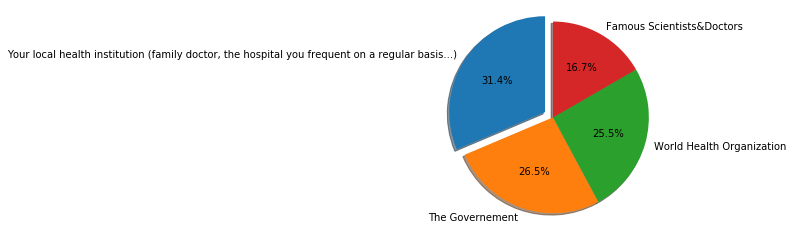

In [102]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = data.groupby('Current_mood')[['Age']].count().sort_values(by='Age',ascending=False).reset_index()['Current_mood'].values
sizes = data.groupby('Current_mood')[['Age']].count().sort_values(by='Age',ascending=False)['Age'].values #random column to count values
explode = (0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [39]:
beta = 0.316
d = 14
gamma = 1/14
mu = 0.048 #average mortality rate

In [16]:
#initializing parameters. Note: I will use data for the attributes, df for the algorithm.
avg_node_degree = int(df['Avg_contacts'].mean())
num_nodes = len(df)

In [17]:
#defining nodes attributes
node_attr = df[['Age', 'Gender', 'Disease', 'Safety',
       'Beloved_sick', 'Economic_impact', 'Individual_risk',
       'Exposed_environment', 'Easily_influenced',  'Avg_contacts',
       'Beloved_care', 'Hypocondriac', 'risk']].to_dict('index')

In [18]:
#defining a bunch of different loss function we are going to introduce in our model, depending on the total number of infected.

def to_binary(x):
    if x<0.5:
        return str('low')
    else:
        return str('high')

def symmetric_loss(preds, train_data):
    y = train_data.get_label()
    beta=1
    preds = 1. / (1. + np.exp(-preds))
    grad = preds*((beta-1)*y+1) - beta*y
    hess = ((beta-1)*y+1)*preds * (1. - preds)
    return grad, hess

def rise_risk_loss(preds, train_data):
    y = train_data.get_label()
    beta=2
    preds = 1. / (1. + np.exp(-preds))
    grad = preds*((beta-1)*y+1) - beta*y
    hess = ((beta-1)*y+1)*preds * (1. - preds)
    return grad, hess

def reduce_risk_loss(preds, train_data):
    y = train_data.get_label()
    gamma = 2
    preds = 1. / (1. + np.exp(-preds))
    grad = preds*((1-y)*gamma+1) - y
    hess = ((y-1)*gamma-y)*preds * (1. - preds)
    return grad, hess


def binary_error(preds, train_data):
    labels = train_data.get_label()
    preds = 1. / (1. + np.exp(-preds))
    return 'error', np.mean(labels != (preds > 0.5)), False



gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                fobj=symmetric_loss,
                feval=binary_error,
                valid_sets=lgb_eval)
gbm_rise_risk = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                fobj=rise_risk_loss,
                feval=binary_error,
                valid_sets=lgb_eval)
gbm_reduce_risk = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                fobj=reduce_risk_loss,
                feval=binary_error,
                valid_sets=lgb_eval)

[1]	valid_0's binary_logloss: 6.26478	valid_0's error: 0.428571
[2]	valid_0's binary_logloss: 5.94491	valid_0's error: 0.428571
[3]	valid_0's binary_logloss: 2.98446	valid_0's error: 0.380952
[4]	valid_0's binary_logloss: 5.70192	valid_0's error: 0.428571
[5]	valid_0's binary_logloss: 2.72976	valid_0's error: 0.380952
[6]	valid_0's binary_logloss: 2.78238	valid_0's error: 0.380952
[7]	valid_0's binary_logloss: 5.55136	valid_0's error: 0.428571
[8]	valid_0's binary_logloss: 5.52266	valid_0's error: 0.428571
[9]	valid_0's binary_logloss: 4.09115	valid_0's error: 0.428571
[10]	valid_0's binary_logloss: 5.49956	valid_0's error: 0.428571
[1]	valid_0's binary_logloss: 1.71467	valid_0's error: 0.380952
[2]	valid_0's binary_logloss: 1.32636	valid_0's error: 0.380952
[3]	valid_0's binary_logloss: 1.11492	valid_0's error: 0.380952
[4]	valid_0's binary_logloss: 0.974492	valid_0's error: 0.380952
[5]	valid_0's binary_logloss: 0.877154	valid_0's error: 0.380952
[6]	valid_0's binary_logloss: 0.81986

In [82]:

import networkx as nx

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid


import random
import numpy as np
import matplotlib.pyplot as plt

import community
from importlib import reload
import networkx as nx
reload(community)



def compute_S(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Susceptible'])

def compute_I(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Infected'])

def compute_R(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Recovered'])

def compute_D(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Dead'])

def compute_risk_index(model): #<---  function to compute how many agents have a high risk perception. 
    return  sum([1 for a in model.schedule.agents if a.risk == 'high'])





class VirusOnNetwork(Model):
    """A virus model with some number of agents"""

    def __init__(
        self,
        num_nodes=100,
        avg_node_degree=10,
        initial_outbreak_size=1,
        virus_spread_chance_low=beta*1.8,
        virus_spread_chance_high = beta*0.8,
        recovery_chance=0.1,
        mortality_rate = 0.3

    ):

        self.num_nodes = num_nodes
        prob = avg_node_degree / (self.num_nodes -1)
        self.G = nx.watts_strogatz_graph(n=self.num_nodes, k = 4, p=prob)
        partition=community.best_partition(self.G)
        #communities = partition.values()
        nx.set_node_attributes(self.G, node_attr)
        comm_df = pd.DataFrame.from_dict(partition, orient = 'index').rename(columns = {0: 'comm'})
        comm_attr = comm_df.to_dict('index')
        
        leaders = []
        for i in comm_df['comm'].unique():
            leaders.append(random.choice(comm_df[comm_df['comm']==i].index))
            
        
        
        nx.set_node_attributes(self.G, comm_attr)
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)
        self.initial_outbreak_size = (
            initial_outbreak_size if initial_outbreak_size <= num_nodes else num_nodes
        )
        self.virus_spread_chance_low = virus_spread_chance_low
        self.virus_spread_chance_high = virus_spread_chance_high
        self.recovery_chance = recovery_chance
        self.mortality_rate = mortality_rate

     #   self.datacollector = DataCollector(
     #       {
     #           "Infected": compute_I,
     #           "Susceptible": compute_S,
     #           "Resistant": compute_R
     #       }
     #   )

    
    
        # DEFINING DIFFERENT CLASSIFIERS, DEPENDING ON THE GLOBAL LEVEL OF INFECTED
        
        
        
        
        # INITIALIZATION OF OUR POPULATION:
        # Create agents
        for i, node in enumerate(self.G.nodes()):
            a = VirusAgent(
                i,
                self,
                initial_state='Susceptible',

                #risk = 'high' if self.G.node[node]['beloved_sick'] == 1 else 'low'

                Age = self.G.nodes[node]['Age'],
                Gender = self.G.nodes[node]['Gender'],
                Disease = self.G.nodes[node]['Disease'],
                Safety = self.G.nodes[node]['Safety'],
                #Current_mood = self.G.nodes[node]['Current_mood'],
                Beloved_sick = self.G.nodes[node]['Beloved_sick'],
                Economic_impact = self.G.nodes[node]['Economic_impact'],
                Individual_risk = self.G.nodes[node]['Individual_risk'],
                Exposed_environment = self.G.nodes[node]['Exposed_environment'],
                Easily_influenced = self.G.nodes[node]['Easily_influenced'],
                #Feeling = self.G.nodes[node]['Feeling'],
                Avg_contacts = self.G.nodes[node]['Avg_contacts'],
                Beloved_care = self.G.nodes[node]['Beloved_care'],
                Hypocondriac = self.G.nodes[node]['Hypocondriac'],

                

                comm = partition.get(node),
                is_leader = 1 if i in leaders else 0,
                risk = self.G.nodes[node]['risk']
                #risk = to_binary(gbm.predict([[self.G.node[node]['Age'],self.G.node[node]['Gender'],
                #                        self.G.node[node]['Disease'], self.G.node[node]['Safety'],
                #                        self.G.node[node]['Beloved_sick'], self.G.node[node]['Economic_impact'], 
                #                        self.G.node[node]['Individual_risk'],self.G.node[node]['Exposed_environment'],
                #                        self.G.node[node]['Easily_influenced'],self.G.node[node]['Avg_contacts'],
                #                        self.G.node[node]['Beloved_care'],self.G.node[node]['Hypocondriac']]])[0])
            )
            
            
            self.schedule.add(a)
            # Add the agent to the node
            self.grid.place_agent(a, node)
            

        # Infect some nodes
        infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)
        for a in self.grid.get_cell_list_contents(infected_nodes):
            a.state = 'Infected'

        self.running = True
        self.datacollector = DataCollector(
            model_reporters={"Infected": compute_I,
                             "Susceptibles": compute_S,
                             "Recovered": compute_R, 
                             "Dead": compute_D,
                             "Risk index": compute_risk_index},
            agent_reporters = {"Risk_perception": 'risk', "Leadership":'is_leader', 'comm': 'comm'})
        #self.datacollector = DataCollector(
        #    agent_reporters={"Risk_perception": "risk"}
        #)
        
        #if the agent is a leader, let's spread the message
        
        
        

 
    def new_outbreak(self):
        infected_nodes = self.random.sample(self.G.nodes(), 15)
        for a in self.grid.get_cell_list_contents(infected_nodes):
            if not a.state == 'Dead':
                a.state = 'Infected'

        
        
        

 

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)
        if random.random()<0.1:
            self.new_outbreak()



class VirusAgent(Agent):
    def __init__(
        self,
        unique_id,
        model,
        initial_state,
        Age,
        Gender,
        Disease,
        Safety,
        #Current_mood,
        Beloved_sick,
        Economic_impact,
        Individual_risk,
        Exposed_environment,
        Easily_influenced,
        #Feeling,
        Avg_contacts,
        Beloved_care,
        Hypocondriac,
        comm,
        is_leader,
        risk):
        super().__init__(unique_id, model)
        

        self.state = initial_state
        self.Age = Age
        self.Gender = Gender
        self.Disease = Disease
        self.Safety = Safety
        #self.Current_mood = Current_mood
        self.Beloved_sick = Beloved_sick
        self.Economic_impact = Economic_impact
        self.Individual_risk = Individual_risk
        self.Exposed_environment = Exposed_environment
        self.Easily_influenced = Easily_influenced
        #self.Feeling = Feeling
        self.Avg_contacts = Avg_contacts
        self.Beloved_care = Beloved_care
        self.Hypocondriac = Hypocondriac   
        self.comm = comm
        self.is_leader = is_leader
        self.risk = risk


    def try_to_infect_neighbors(self):
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if agent.state == 'Susceptible'
        ]
        
        
        global_infected = sum([1 for a in model.schedule.agents if a.state == 'Infected'])
        if global_infected/self.model.num_nodes<0.1:
            gb_clf = gbm_reduce_risk
        elif global_infected/self.model.num_nodes<0.5:
            gb_clf = gbm
        else:
            gb_clf = gbm_rise_risk
        
        #those who have a low risk perception, will have stupid behaviors. I will use a constant of proportionality
        #to increase their chance to be infected
        for a in susceptible_neighbors:
            if a.risk=='low':
                if self.random.random() < self.model.virus_spread_chance_low:
                    a.state = 'Infected'
                    for b in [x for x in self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(a.unique_id))]:
                        b.Beloved_sick = 1
                        b.risk = to_binary(gb_clf.predict([[b.Age,b.Gender, b.Disease, b.Safety, b.Beloved_sick,b.Economic_impact,
                                                  b.Individual_risk, b.Exposed_environment, b.Easily_influenced,
                                                  b.Avg_contacts, b.Beloved_care, b.Hypocondriac]])[0])
                        #self.model.G.node[node]['beloved_sick'] = 1
                        #self.model.G.node[node]['risk'] = str(clf.predict([[self.model.G.node[node]['beloved_sick'],self.model.G.node[node]['disease']]]))
            elif a.risk == 'high':
                if self.random.random() < self.model.virus_spread_chance_high:
                    a.state = 'Infected'
                    for b in [x for x in self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(a.unique_id))]:
                        b.Beloved_sick = 1
                        b.risk = to_binary(gb_clf.predict([[b.Age,b.Gender, b.Disease, b.Safety, b.Beloved_sick,b.Economic_impact,
                                                  b.Individual_risk, b.Exposed_environment, b.Easily_influenced,
                                                  b.Avg_contacts, b.Beloved_care, b.Hypocondriac]])[0])
                    #for node in self.model.grid.get_neighbors(a.unique_id):
                        #self.model.G.node[node]['beloved_sick'] = 1
                        #self.model.G.node[node]['risk'] = str(clf.predict([[self.model.G.node[node]['beloved_sick'],self.model.G.node[node]['disease']]]))
                



    def try_remove_infection(self):
        # Try to remove
        if self.random.random() < self.model.recovery_chance:
            # Success
            self.state = 'Recovered'
            
    def pass_away(self):
        if self.random.random() < self.model.mortality_rate:
            self.state = 'Dead'
            
    def spread_message(self):
        comm_nodes = [node for node in self.model.G.nodes if self.model.G.nodes[node]['comm'] == self.comm]
        influenced_nodes = random.sample(comm_nodes, int(0.314*len(comm_nodes)))
        for agent in self.model.grid.get_cell_list_contents(influenced_nodes):
            agent.risk = 'high'
            for neigh in [x for x in self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(agent.unique_id))]:
                if neigh.Easily_influenced == 1:
                    neigh.risk = 'high'
            
    def get_young_message(self):
        features = random.sample(['Individual_risk', 'Beloved_care'], random.randint(1,2))
        if 'Individual_risk' in features:
            self.my_risk = 1
        if 'Beloved_care' in features:
            self.think_at_beloved = 1
            
        global_infected = sum([1 for a in model.schedule.agents if a.state == 'Infected'])
        if global_infected/self.model.num_nodes<0.3:
            gb_clf = gbm_reduce_risk
        elif global_infected/self.model.num_nodes<0.6:
            gb_clf = gbm
        else:
            gb_clf = gbm_rise_risk
            
        self.risk = to_binary(gb_clf.predict([[self.Age,self.Gender, self.Disease, self.Safety, self.Beloved_sick,self.Economic_impact,
                                                  self.Individual_risk, self.Exposed_environment, self.Easily_influenced,
                                                  self.Avg_contacts, self.Beloved_care, self.Hypocondriac]])[0])
        
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        for agent in self.model.grid.get_cell_list_contents(neighbors_nodes):
            if agent.Easily_influenced == 1:
                agent.risk = 'high'
        

    def step(self):
        if self.state == 'Infected':
            self.try_to_infect_neighbors()
            self.try_remove_infection()
            self.pass_away()
                        
        if self.is_leader:
            self.spread_message()
            
        if self.Age<30:
            self.get_young_message()



In [83]:
model = VirusOnNetwork(num_nodes, avg_node_degree,15, beta*1.8,beta*0.8,gamma, mu) 
while model.running and model.schedule.steps < 100:
    model.step()
print(model.schedule.steps)


100


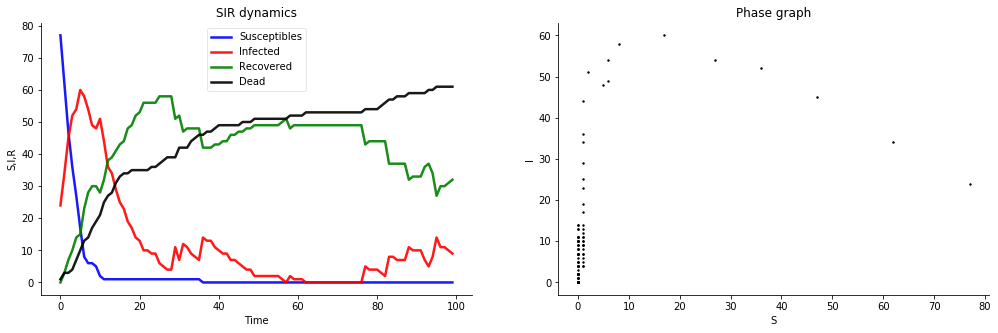

In [85]:
# PLOT
RES = model.datacollector.get_model_vars_dataframe()
fig, axs = plt.subplots(nrows=1, ncols=2, facecolor='w', figsize=(17,5))

ax = axs[0]
ax.set_title('SIR dynamics')
ax.plot(RES.index, RES.Susceptibles, 'b', alpha=0.9, lw=2.5, label= 'Susceptibles')
ax.plot(RES.index, RES.Infected, 'r', alpha=0.9, lw=2.5, label= 'Infected')
ax.plot(RES.index, RES.Recovered, 'g', alpha=0.9, lw=2.5, label= 'Recovered')
ax.plot(RES.index, RES.Dead, 'black', alpha=0.9, lw=2.5, label= 'Dead')
ax.set_xlabel('Time')
ax.set_ylabel('S,I,R')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)

ax = axs[1]
ax.set_title('Phase graph')
ax.scatter(RES.Susceptibles, RES.Infected ,s=2, facecolor='k')

ax.set_xlabel('S')
ax.set_ylabel('I')


for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)

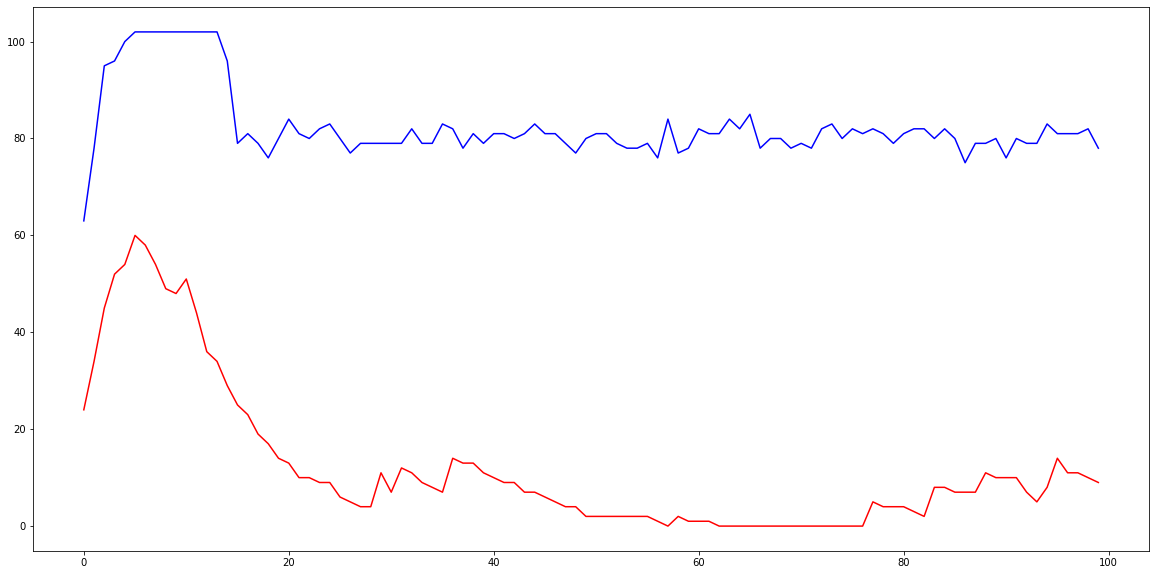

In [86]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(RES['Risk index'], 'b-')
ax.plot(RES['Infected'], 'r-')


In [87]:
RES['Risk index'].corr(RES['Infected'])

0.8032549586033714

In [78]:
'''Running the experiments'''


fixed_params = {'num_nodes':num_nodes, 'avg_node_degree':avg_node_degree, 'initial_outbreak_size':1
                , 'virus_spread_chance_low':beta*1.8, 'virus_spread_chance_high':beta*0.8, 'recovery_chance': gamma, 'mortality_rate': mu}

variable_params = {}

batch_run = BatchRunner(
    VirusOnNetwork,  
    variable_params, 
    fixed_params, 
    iterations=30, 
    max_steps=60, 
    model_reporters={"Data Collector": lambda m: m.datacollector.get_model_vars_dataframe()}) 
# Run the experiments
batch_run.run_all()  # this can take a bit

30it [01:10,  2.36s/it]


Simulation n°: 29
Done!


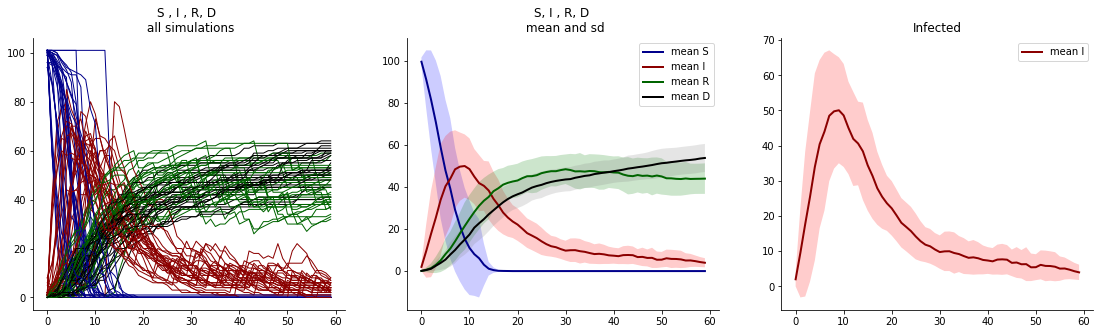

In [79]:
import sys



RES = batch_run.get_model_vars_dataframe()

nsim=50
Ss = []
Is= []
Rs = []
Ds = []
for isim in range(RES.shape[0]):
    sys.stdout.write('\rSimulation n°: {}'.format(isim))
    I = RES['Data Collector'][isim].Infected
    S = RES['Data Collector'][isim].Susceptibles
    R = RES['Data Collector'][isim].Recovered
    D = RES['Data Collector'][isim].Dead
    
    Ss.append(S)
    Is.append(I)
    Rs.append(R)
    Ds.append(D)
print('\nDone!') 

'''
Compute mean and sd of our simulations
'''
meanS = np.mean(Ss, axis=0)
meanI = np.mean(Is, axis=0)
meanR = np.mean(Rs, axis=0)
meanD = np.mean(Ds, axis=0)

sdS = np.std(Ss, axis=0, dtype=np.float64)
sdI = np.std(Is, axis=0, dtype=np.float64)
sdR = np.std(Rs, axis=0, dtype=np.float64)
sdD = np.std(Ds, axis=0, dtype=np.float64)

'''
Some Plots
'''
t = np.arange(0, len(meanS), 1)
fig, axs = plt.subplots(1,3, facecolor='w', figsize=(19,5))

axs[0].set_title('S , I , R, D \n all simulations')
for  S, I,R,D in zip(Ss, Is, Rs,Ds):
    axs[0].plot(t, S, c = 'darkblue', lw=1)
    axs[0].plot(t, I, c = 'darkred', lw=1)
    axs[0].plot(t, R, c = 'darkgreen', lw=1)
    axs[0].plot(t, D, c = 'black', lw=1)
    


axs[1].set_title('S, I , R, D \n mean and sd')
axs[1].plot(t, meanS, c = 'darkblue', lw=2, label = 'mean S')
axs[1].plot(t, meanI, c = 'darkred', lw=2, label = 'mean I')
axs[1].plot(t, meanR, c = 'darkgreen', lw=2, label = 'mean R')
axs[1].plot(t, meanD, c = 'black', lw=2, label = 'mean D')
axs[1].fill_between(t, meanS+sdS, meanS-sdS, facecolor='blue', alpha=0.2)
axs[1].fill_between(t, meanI+sdI, meanI-sdI, facecolor='r', alpha=0.2)
axs[1].fill_between(t, meanR+sdR, meanR-sdR, facecolor='g', alpha=0.2)
axs[1].fill_between(t, meanD+sdD, meanD-sdD, facecolor='gray', alpha=0.2)
axs[1].legend(fancybox = True)


axs[2].set_title('Infected')
axs[2].plot(t, meanI, c = 'darkred', lw=2, label = 'mean I')
axs[2].fill_between(t, meanI+sdI, meanI-sdI, facecolor='r', alpha=0.2)
axs[2].legend(fancybox = True)
    
for i in range(3):
    #axs[i].legend(fancybox = True)
    for spine in ('top', 'right'): 
        axs[i].spines[spine].set_visible(False)

In [80]:
I_complete = meanI

## ABM with no interventions <a name="abm_noint"></a>

In [73]:

import networkx as nx

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid


import random
import numpy as np
import matplotlib.pyplot as plt

import community
from importlib import reload
import networkx as nx
reload(community)



def compute_S(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Susceptible'])

def compute_I(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Infected'])

def compute_R(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Recovered'])

def compute_D(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Dead'])

def compute_risk_index(model): #<---  function to compute how many agents have a high risk perception. 
    return  sum([1 for a in model.schedule.agents if a.risk == 'high'])





class VirusOnNetwork(Model):
    """A virus model with some number of agents"""

    def __init__(
        self,
        num_nodes=100,
        avg_node_degree=10,
        initial_outbreak_size=1,
        virus_spread_chance_low=beta*1.8,
        virus_spread_chance_high = beta*0.8,
        recovery_chance=0.1,
        mortality_rate = 0.3

    ):

        self.num_nodes = num_nodes
        prob = avg_node_degree / (self.num_nodes -1)
        self.G = nx.watts_strogatz_graph(n=self.num_nodes, k = 4, p=prob)
        partition=community.best_partition(self.G)
        #communities = partition.values()
        nx.set_node_attributes(self.G, node_attr)
        comm_df = pd.DataFrame.from_dict(partition, orient = 'index').rename(columns = {0: 'comm'})
        comm_attr = comm_df.to_dict('index')
        
        leaders = []
        for i in comm_df['comm'].unique():
            leaders.append(random.choice(comm_df[comm_df['comm']==i].index))
            
        
        
        nx.set_node_attributes(self.G, comm_attr)
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)
        self.initial_outbreak_size = (
            initial_outbreak_size if initial_outbreak_size <= num_nodes else num_nodes
        )
        self.virus_spread_chance_low = virus_spread_chance_low
        self.virus_spread_chance_high = virus_spread_chance_high
        self.recovery_chance = recovery_chance
        self.mortality_rate = mortality_rate

     #   self.datacollector = DataCollector(
     #       {
     #           "Infected": compute_I,
     #           "Susceptible": compute_S,
     #           "Resistant": compute_R
     #       }
     #   )

    
    
        # DEFINING DIFFERENT CLASSIFIERS, DEPENDING ON THE GLOBAL LEVEL OF INFECTED
        
        
        
        
        # INITIALIZATION OF OUR POPULATION:
        # Create agents
        for i, node in enumerate(self.G.nodes()):
            a = VirusAgent(
                i,
                self,
                initial_state='Susceptible',

                #risk = 'high' if self.G.node[node]['beloved_sick'] == 1 else 'low'

                Age = self.G.nodes[node]['Age'],
                Gender = self.G.nodes[node]['Gender'],
                Disease = self.G.nodes[node]['Disease'],
                Safety = self.G.nodes[node]['Safety'],
                #Current_mood = self.G.nodes[node]['Current_mood'],
                Beloved_sick = self.G.nodes[node]['Beloved_sick'],
                Economic_impact = self.G.nodes[node]['Economic_impact'],
                Individual_risk = self.G.nodes[node]['Individual_risk'],
                Exposed_environment = self.G.nodes[node]['Exposed_environment'],
                Easily_influenced = self.G.nodes[node]['Easily_influenced'],
                #Feeling = self.G.nodes[node]['Feeling'],
                Avg_contacts = self.G.nodes[node]['Avg_contacts'],
                Beloved_care = self.G.nodes[node]['Beloved_care'],
                Hypocondriac = self.G.nodes[node]['Hypocondriac'],

                

                comm = partition.get(node),
                is_leader = 1 if i in leaders else 0,
                risk = self.G.nodes[node]['risk']
                #risk = to_binary(gbm.predict([[self.G.node[node]['Age'],self.G.node[node]['Gender'],
                #                        self.G.node[node]['Disease'], self.G.node[node]['Safety'],
                #                        self.G.node[node]['Beloved_sick'], self.G.node[node]['Economic_impact'], 
                #                        self.G.node[node]['Individual_risk'],self.G.node[node]['Exposed_environment'],
                #                        self.G.node[node]['Easily_influenced'],self.G.node[node]['Avg_contacts'],
                #                        self.G.node[node]['Beloved_care'],self.G.node[node]['Hypocondriac']]])[0])
            )
            
            
            self.schedule.add(a)
            # Add the agent to the node
            self.grid.place_agent(a, node)
            

        # Infect some nodes
        infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)
        for a in self.grid.get_cell_list_contents(infected_nodes):
            a.state = 'Infected'

        self.running = True
        self.datacollector = DataCollector(
            model_reporters={"Infected": compute_I,
                             "Susceptibles": compute_S,
                             "Recovered": compute_R, 
                             "Dead": compute_D,
                             "Risk index": compute_risk_index},
            agent_reporters = {"Risk_perception": 'risk', "Leadership":'is_leader', 'comm': 'comm'})
        #self.datacollector = DataCollector(
        #    agent_reporters={"Risk_perception": "risk"}
        #)
        
        #if the agent is a leader, let's spread the message
        
    def new_outbreak(self):
        infected_nodes = self.random.sample(self.G.nodes(), 15)
        for a in self.grid.get_cell_list_contents(infected_nodes):
            if not a.state == 'Dead':
                a.state = 'Infected'

        
        
        

 

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)
        if random.random()<0.1:
            self.new_outbreak()



class VirusAgent(Agent):
    def __init__(
        self,
        unique_id,
        model,
        initial_state,
        Age,
        Gender,
        Disease,
        Safety,
        #Current_mood,
        Beloved_sick,
        Economic_impact,
        Individual_risk,
        Exposed_environment,
        Easily_influenced,
        #Feeling,
        Avg_contacts,
        Beloved_care,
        Hypocondriac,
        comm,
        is_leader,
        risk):
        super().__init__(unique_id, model)
        

        self.state = initial_state
        self.Age = Age
        self.Gender = Gender
        self.Disease = Disease
        self.Safety = Safety
        #self.Current_mood = Current_mood
        self.Beloved_sick = Beloved_sick
        self.Economic_impact = Economic_impact
        self.Individual_risk = Individual_risk
        self.Exposed_environment = Exposed_environment
        self.Easily_influenced = Easily_influenced
        #self.Feeling = Feeling
        self.Avg_contacts = Avg_contacts
        self.Beloved_care = Beloved_care
        self.Hypocondriac = Hypocondriac   
        self.comm = comm
        self.is_leader = is_leader
        self.risk = risk


    def try_to_infect_neighbors(self):
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if agent.state == 'Susceptible'
        ]
        
        
        global_infected = sum([1 for a in model.schedule.agents if a.state == 'Infected'])
        if global_infected/self.model.num_nodes<0.1:
            gb_clf = gbm_reduce_risk
        elif global_infected/self.model.num_nodes<0.5:
            gb_clf = gbm
        else:
            gb_clf = gbm_rise_risk
        
        #those who have a low risk perception, will have stupid behaviors. I will use a constant of proportionality
        #to increase their chance to be infected
        for a in susceptible_neighbors:
            if a.risk=='low':
                if self.random.random() < self.model.virus_spread_chance_low:
                    a.state = 'Infected'
                    for b in [x for x in self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(a.unique_id))]:
                        b.Beloved_sick = 1
                        b.risk = to_binary(gb_clf.predict([[b.Age,b.Gender, b.Disease, b.Safety, b.Beloved_sick,b.Economic_impact,
                                                  b.Individual_risk, b.Exposed_environment, b.Easily_influenced,
                                                  b.Avg_contacts, b.Beloved_care, b.Hypocondriac]])[0])
                        #self.model.G.node[node]['beloved_sick'] = 1
                        #self.model.G.node[node]['risk'] = str(clf.predict([[self.model.G.node[node]['beloved_sick'],self.model.G.node[node]['disease']]]))
            elif a.risk == 'high':
                if self.random.random() < self.model.virus_spread_chance_high:
                    a.state = 'Infected'
                    for b in [x for x in self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(a.unique_id))]:
                        b.Beloved_sick = 1
                        b.risk = to_binary(gb_clf.predict([[b.Age,b.Gender, b.Disease, b.Safety, b.Beloved_sick,b.Economic_impact,
                                                  b.Individual_risk, b.Exposed_environment, b.Easily_influenced,
                                                  b.Avg_contacts, b.Beloved_care, b.Hypocondriac]])[0])
                    #for node in self.model.grid.get_neighbors(a.unique_id):
                        #self.model.G.node[node]['beloved_sick'] = 1
                        #self.model.G.node[node]['risk'] = str(clf.predict([[self.model.G.node[node]['beloved_sick'],self.model.G.node[node]['disease']]]))
                



    def try_remove_infection(self):
        # Try to remove
        if self.random.random() < self.model.recovery_chance:
            # Success
            self.state = 'Recovered'
            
    def pass_away(self):
        if self.random.random() < self.model.mortality_rate:
            self.state = 'Dead'
            
    def relax(self):
        gb_clf = gbm_reduce_risk
        self.Individual_risk=0
        self.Safety=1
        self.risk = to_binary(gb_clf.predict([[self.Age,self.Gender, self.Disease, self.Safety, self.Beloved_sick,self.Economic_impact,
                                                  self.Individual_risk, self.Exposed_environment, self.Easily_influenced,
                                                  self.Avg_contacts, self.Beloved_care, self.Hypocondriac]])[0])
            
    def spread_message(self):
        comm_nodes = [node for node in self.model.G.nodes if self.model.G.nodes[node]['comm'] == self.comm]
        influenced_nodes = random.sample(comm_nodes, int(0.314*len(comm_nodes)))
        for agent in self.model.grid.get_cell_list_contents(influenced_nodes):
            agent.risk = 'high'
            for neigh in [x for x in self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(agent.unique_id))]:
                if neigh.Easily_influenced == 1:
                    neigh.risk = 'high'
            
    def get_young_message(self):
        features = random.sample(['Individual_risk', 'Beloved_care'], random.randint(1,2))
        if 'Individual_risk' in features:
            self.my_risk = 1
        if 'Beloved_care' in features:
            self.think_at_beloved = 1
            
        global_infected = sum([1 for a in model.schedule.agents if a.state == 'Infected'])
        if global_infected/self.model.num_nodes<0.3:
            gb_clf = gbm_reduce_risk
        elif global_infected/self.model.num_nodes<0.6:
            gb_clf = gbm
        else:
            gb_clf = gbm_rise_risk
            
        self.risk = to_binary(gb_clf.predict([[self.Age,self.Gender, self.Disease, self.Safety, self.Beloved_sick,self.Economic_impact,
                                                  self.Individual_risk, self.Exposed_environment, self.Easily_influenced,
                                                  self.Avg_contacts, self.Beloved_care, self.Hypocondriac]])[0])
        
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        for agent in self.model.grid.get_cell_list_contents(neighbors_nodes):
            if agent.Easily_influenced == 1:
                agent.risk = 'high'
        

    def step(self):
        if self.state == 'Infected':
            self.try_to_infect_neighbors()
            self.try_remove_infection()
            self.pass_away()
        if sum([1 for a in model.schedule.agents if a.state == 'Infected'])/self.model.num_nodes<0.2 and self.Disease==0:
            self.relax()
                        
        #if self.is_leader:
        #    self.spread_message()
            
        #if self.Age<30:
        #    self.get_young_message()



In [48]:
model = VirusOnNetwork(num_nodes, avg_node_degree,15, beta*1.8,beta*0.8, gamma, mu) 
while model.running and model.schedule.steps < 100:
    model.step()
print(model.schedule.steps)


100


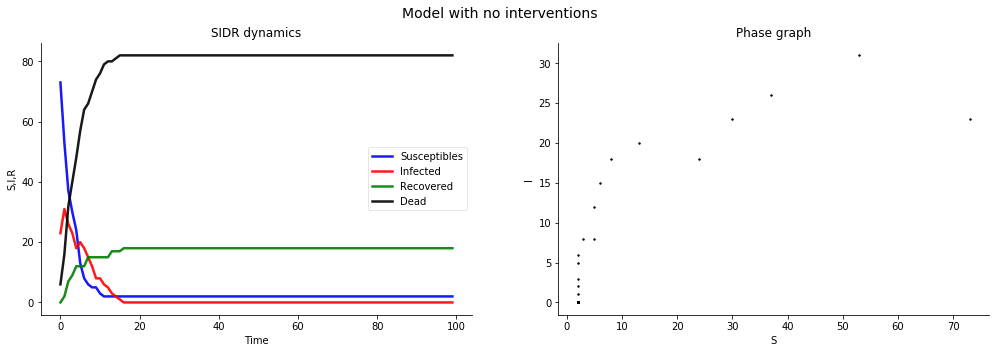

In [49]:
# PLOT
RES = model.datacollector.get_model_vars_dataframe()
fig, axs = plt.subplots(nrows=1, ncols=2, facecolor='w', figsize=(17,5))
fig.suptitle('Model with no interventions', fontsize=14)

ax = axs[0]
ax.set_title('SIDR dynamics')
ax.plot(RES.index, RES.Susceptibles, 'b', alpha=0.9, lw=2.5, label= 'Susceptibles')
ax.plot(RES.index, RES.Infected, 'r', alpha=0.9, lw=2.5, label= 'Infected')
ax.plot(RES.index, RES.Recovered, 'g', alpha=0.9, lw=2.5, label= 'Recovered')
ax.plot(RES.index, RES.Dead, 'black', alpha=0.9, lw=2.5, label= 'Dead')
ax.set_xlabel('Time')
ax.set_ylabel('S,I,R')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)

ax = axs[1]
ax.set_title('Phase graph')
ax.scatter(RES.Susceptibles, RES.Infected ,s=2, facecolor='k')

ax.set_xlabel('S')
ax.set_ylabel('I')


for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)



30it [00:36,  1.22s/it]


Simulation n°: 29
Done!


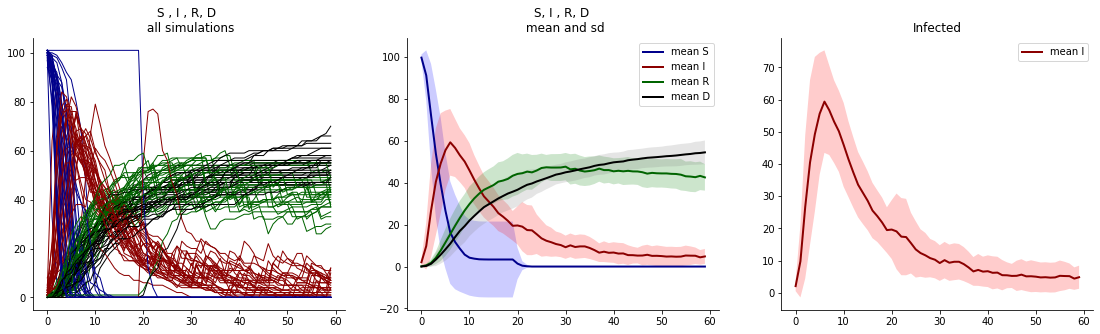

In [74]:
import sys

'''Running the experiments'''


fixed_params = {'num_nodes':num_nodes, 'avg_node_degree':avg_node_degree, 'initial_outbreak_size':1
                , 'virus_spread_chance_low':beta*1.8, 'virus_spread_chance_high':beta*0.8, 'recovery_chance': gamma, 'mortality_rate': mu}

variable_params = {}

batch_run = BatchRunner(
    VirusOnNetwork,  
    variable_params, 
    fixed_params, 
    iterations=30, 
    max_steps=60, 
    model_reporters={"Data Collector": lambda m: m.datacollector.get_model_vars_dataframe()}) 
# Run the experiments
batch_run.run_all()  # this can take a bit

RES = batch_run.get_model_vars_dataframe()

nsim=50
Ss = []
Is= []
Rs = []
Ds = []
for isim in range(RES.shape[0]):
    sys.stdout.write('\rSimulation n°: {}'.format(isim))
    I = RES['Data Collector'][isim].Infected
    S = RES['Data Collector'][isim].Susceptibles
    R = RES['Data Collector'][isim].Recovered
    D = RES['Data Collector'][isim].Dead
    
    Ss.append(S)
    Is.append(I)
    Rs.append(R)
    Ds.append(D)
print('\nDone!') 

'''
Compute mean and sd of our simulations
'''
meanS = np.mean(Ss, axis=0)
meanI = np.mean(Is, axis=0)
meanR = np.mean(Rs, axis=0)
meanD = np.mean(Ds, axis=0)

sdS = np.std(Ss, axis=0, dtype=np.float64)
sdI = np.std(Is, axis=0, dtype=np.float64)
sdR = np.std(Rs, axis=0, dtype=np.float64)
sdD = np.std(Ds, axis=0, dtype=np.float64)

'''
Some Plots
'''
t = np.arange(0, len(meanS), 1)
fig, axs = plt.subplots(1,3, facecolor='w', figsize=(19,5))

axs[0].set_title('S , I , R, D \n all simulations')
for  S, I,R,D in zip(Ss, Is, Rs,Ds):
    axs[0].plot(t, S, c = 'darkblue', lw=1)
    axs[0].plot(t, I, c = 'darkred', lw=1)
    axs[0].plot(t, R, c = 'darkgreen', lw=1)
    axs[0].plot(t, D, c = 'black', lw=1)
    


axs[1].set_title('S, I , R, D \n mean and sd')
axs[1].plot(t, meanS, c = 'darkblue', lw=2, label = 'mean S')
axs[1].plot(t, meanI, c = 'darkred', lw=2, label = 'mean I')
axs[1].plot(t, meanR, c = 'darkgreen', lw=2, label = 'mean R')
axs[1].plot(t, meanD, c = 'black', lw=2, label = 'mean D')
axs[1].fill_between(t, meanS+sdS, meanS-sdS, facecolor='blue', alpha=0.2)
axs[1].fill_between(t, meanI+sdI, meanI-sdI, facecolor='r', alpha=0.2)
axs[1].fill_between(t, meanR+sdR, meanR-sdR, facecolor='g', alpha=0.2)
axs[1].fill_between(t, meanD+sdD, meanD-sdD, facecolor='gray', alpha=0.2)
axs[1].legend(fancybox = True)


axs[2].set_title('Infected')
axs[2].plot(t, meanI, c = 'darkred', lw=2, label = 'mean I')
axs[2].fill_between(t, meanI+sdI, meanI-sdI, facecolor='r', alpha=0.2)
axs[2].legend(fancybox = True)
    
for i in range(3):
    #axs[i].legend(fancybox = True)
    for spine in ('top', 'right'): 
        axs[i].spines[spine].set_visible(False)

In [75]:
I_basic = meanI

## ABM with community leaders <a name="abm_comm"></a>

In [64]:

import networkx as nx

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid


import random
import numpy as np
import matplotlib.pyplot as plt

import community
from importlib import reload
import networkx as nx
reload(community)



def compute_S(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Susceptible'])

def compute_I(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Infected'])

def compute_R(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Recovered'])

def compute_D(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Dead'])

def compute_risk_index(model): #<---  function to compute how many agents have a high risk perception. 
    return  sum([1 for a in model.schedule.agents if a.risk == 'high'])





class VirusOnNetwork(Model):
    """A virus model with some number of agents"""

    def __init__(
        self,
        num_nodes=100,
        avg_node_degree=10,
        initial_outbreak_size=1,
        virus_spread_chance_low=beta*1.8,
        virus_spread_chance_high = beta*0.8,
        recovery_chance=gamma,
        mortality_rate=mu
    ):

        self.num_nodes = num_nodes
        prob = avg_node_degree / (self.num_nodes -1)
        self.G = nx.watts_strogatz_graph(n=self.num_nodes, k = 4, p=prob)
        partition=community.best_partition(self.G)
        #communities = partition.values()
        nx.set_node_attributes(self.G, node_attr)
        comm_df = pd.DataFrame.from_dict(partition, orient = 'index').rename(columns = {0: 'comm'})
        comm_attr = comm_df.to_dict('index')
        
        leaders = []
        for i in comm_df['comm'].unique():
            leaders.append(random.choice(comm_df[comm_df['comm']==i].index))
            
        
        
        nx.set_node_attributes(self.G, comm_attr)
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)
        self.initial_outbreak_size = (
            initial_outbreak_size if initial_outbreak_size <= num_nodes else num_nodes
        )
        self.virus_spread_chance_low = virus_spread_chance_low
        self.virus_spread_chance_high = virus_spread_chance_high
        self.recovery_chance = recovery_chance
        self.mortality_rate = mortality_rate


     #   self.datacollector = DataCollector(
     #       {
     #           "Infected": compute_I,
     #           "Susceptible": compute_S,
     #           "Resistant": compute_R
     #       }
     #   )

    
    
        # DEFINING DIFFERENT CLASSIFIERS, DEPENDING ON THE GLOBAL LEVEL OF INFECTED
        
        
        
        
        # INITIALIZATION OF OUR POPULATION:
        # Create agents
        for i, node in enumerate(self.G.nodes()):
            a = VirusAgent(
                i,
                self,
                initial_state='Susceptible',

                #risk = 'high' if self.G.node[node]['beloved_sick'] == 1 else 'low'

                Age = self.G.nodes[node]['Age'],
                Gender = self.G.nodes[node]['Gender'],
                Disease = self.G.nodes[node]['Disease'],
                Safety = self.G.nodes[node]['Safety'],
                #Current_mood = self.G.nodes[node]['Current_mood'],
                Beloved_sick = self.G.nodes[node]['Beloved_sick'],
                Economic_impact = self.G.nodes[node]['Economic_impact'],
                Individual_risk = self.G.nodes[node]['Individual_risk'],
                Exposed_environment = self.G.nodes[node]['Exposed_environment'],
                Easily_influenced = self.G.nodes[node]['Easily_influenced'],
                #Feeling = self.G.nodes[node]['Feeling'],
                Avg_contacts = self.G.nodes[node]['Avg_contacts'],
                Beloved_care = self.G.nodes[node]['Beloved_care'],
                Hypocondriac = self.G.nodes[node]['Hypocondriac'],

                

                comm = partition.get(node),
                is_leader = 1 if i in leaders else 0,
                risk = self.G.nodes[node]['risk']
                #risk = to_binary(gbm.predict([[self.G.node[node]['Age'],self.G.node[node]['Gender'],
                #                        self.G.node[node]['Disease'], self.G.node[node]['Safety'],
                #                        self.G.node[node]['Beloved_sick'], self.G.node[node]['Economic_impact'], 
                #                        self.G.node[node]['Individual_risk'],self.G.node[node]['Exposed_environment'],
                #                        self.G.node[node]['Easily_influenced'],self.G.node[node]['Avg_contacts'],
                #                        self.G.node[node]['Beloved_care'],self.G.node[node]['Hypocondriac']]])[0])
            )
            
            
            self.schedule.add(a)
            # Add the agent to the node
            self.grid.place_agent(a, node)
            

        # Infect some nodes
        infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)
        for a in self.grid.get_cell_list_contents(infected_nodes):
            a.state = 'Infected'

        self.running = True
        self.datacollector = DataCollector(
            model_reporters={"Infected": compute_I,
                             "Susceptibles": compute_S,
                             "Recovered": compute_R, 
                             "Dead": compute_D,
                             "Risk index": compute_risk_index},
            agent_reporters = {"Risk_perception": 'risk', "Leadership":'is_leader', 'comm': 'comm'})
        #self.datacollector = DataCollector(
        #    agent_reporters={"Risk_perception": "risk"}
        #)
        
        #if the agent is a leader, let's spread the message

    def new_outbreak(self):
        infected_nodes = self.random.sample(self.G.nodes(), 15)
        for a in self.grid.get_cell_list_contents(infected_nodes):
            if not a.state == 'Dead':
                a.state = 'Infected'

        
        
        

 

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)
        if random.random()<0.1:
            self.new_outbreak()



class VirusAgent(Agent):
    def __init__(
        self,
        unique_id,
        model,
        initial_state,
        Age,
        Gender,
        Disease,
        Safety,
        #Current_mood,
        Beloved_sick,
        Economic_impact,
        Individual_risk,
        Exposed_environment,
        Easily_influenced,
        #Feeling,
        Avg_contacts,
        Beloved_care,
        Hypocondriac,
        comm,
        is_leader,
        risk):
        super().__init__(unique_id, model)
        

        self.state = initial_state
        self.Age = Age
        self.Gender = Gender
        self.Disease = Disease
        self.Safety = Safety
        #self.Current_mood = Current_mood
        self.Beloved_sick = Beloved_sick
        self.Economic_impact = Economic_impact
        self.Individual_risk = Individual_risk
        self.Exposed_environment = Exposed_environment
        self.Easily_influenced = Easily_influenced
        #self.Feeling = Feeling
        self.Avg_contacts = Avg_contacts
        self.Beloved_care = Beloved_care
        self.Hypocondriac = Hypocondriac   
        self.comm = comm
        self.is_leader = is_leader
        self.risk = risk


    def try_to_infect_neighbors(self):
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if agent.state == 'Susceptible'
        ]
        
        
        global_infected = sum([1 for a in model.schedule.agents if a.state == 'Infected'])
        if global_infected/self.model.num_nodes<0.1:
            gb_clf = gbm_reduce_risk
        elif global_infected/self.model.num_nodes<0.5:
            gb_clf = gbm
        else:
            gb_clf = gbm_rise_risk
        
        #those who have a low risk perception, will have stupid behaviors. I will use a constant of proportionality
        #to increase their chance to be infected
        for a in susceptible_neighbors:
            if a.risk=='low':
                if self.random.random() < self.model.virus_spread_chance_low:
                    a.state = 'Infected'
                    for b in [x for x in self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(a.unique_id))]:
                        b.Beloved_sick = 1
                        b.risk = to_binary(gb_clf.predict([[b.Age,b.Gender, b.Disease, b.Safety, b.Beloved_sick,b.Economic_impact,
                                                  b.Individual_risk, b.Exposed_environment, b.Easily_influenced,
                                                  b.Avg_contacts, b.Beloved_care, b.Hypocondriac]])[0])
                        #self.model.G.node[node]['beloved_sick'] = 1
                        #self.model.G.node[node]['risk'] = str(clf.predict([[self.model.G.node[node]['beloved_sick'],self.model.G.node[node]['disease']]]))
            elif a.risk == 'high':
                if self.random.random() < self.model.virus_spread_chance_high:
                    a.state = 'Infected'
                    for b in [x for x in self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(a.unique_id))]:
                        b.Beloved_sick = 1
                        b.risk = to_binary(gb_clf.predict([[b.Age,b.Gender, b.Disease, b.Safety, b.Beloved_sick,b.Economic_impact,
                                                  b.Individual_risk, b.Exposed_environment, b.Easily_influenced,
                                                  b.Avg_contacts, b.Beloved_care, b.Hypocondriac]])[0])
                    #for node in self.model.grid.get_neighbors(a.unique_id):
                        #self.model.G.node[node]['beloved_sick'] = 1
                        #self.model.G.node[node]['risk'] = str(clf.predict([[self.model.G.node[node]['beloved_sick'],self.model.G.node[node]['disease']]]))
                



    def try_remove_infection(self):
        # Try to remove
        if self.random.random() < self.model.recovery_chance:
            # Success
            self.state = 'Recovered'
            
    def pass_away(self):
        if self.random.random() < self.model.mortality_rate:
            self.state = 'Dead'
            
    def spread_message(self):
        comm_nodes = [node for node in self.model.G.nodes if self.model.G.nodes[node]['comm'] == self.comm]
        influenced_nodes = random.sample(comm_nodes, int(0.7*len(comm_nodes)))
        for agent in self.model.grid.get_cell_list_contents(influenced_nodes):
            agent.risk = 'high'
            for neigh in [x for x in self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(agent.unique_id))]:
                if neigh.Easily_influenced == 1:
                    neigh.risk = 'high'
            
    def get_young_message(self):
        features = random.sample(['Individual_risk', 'Beloved_care'], random.randint(1,2))
        if 'Individual_risk' in features:
            self.my_risk = 1
        if 'Beloved_care' in features:
            self.think_at_beloved = 1
            
        global_infected = sum([1 for a in model.schedule.agents if a.state == 'Infected'])
        if global_infected/self.model.num_nodes<0.3:
            gb_clf = gbm_reduce_risk
        elif global_infected/self.model.num_nodes<0.6:
            gb_clf = gbm
        else:
            gb_clf = gbm_rise_risk
            
        self.risk = to_binary(gb_clf.predict([[self.Age,self.Gender, self.Disease, self.Safety, self.Beloved_sick,self.Economic_impact,
                                                  self.Individual_risk, self.Exposed_environment, self.Easily_influenced,
                                                  self.Avg_contacts, self.Beloved_care, self.Hypocondriac]])[0])
        
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        for agent in self.model.grid.get_cell_list_contents(neighbors_nodes):
            if agent.Easily_influenced == 1:
                agent.risk = 'high'

    def relax(self):
        gb_clf = gbm_reduce_risk
        self.Individual_risk=0
        self.Safety=1
        self.risk = to_binary(gb_clf.predict([[self.Age,self.Gender, self.Disease, self.Safety, self.Beloved_sick,self.Economic_impact,
                                                  self.Individual_risk, self.Exposed_environment, self.Easily_influenced,
                                                  self.Avg_contacts, self.Beloved_care, self.Hypocondriac]])[0])
        

    def step(self):
        if self.state == 'Infected':
            self.try_to_infect_neighbors()
            self.try_remove_infection()
            self.pass_away()
                        
        if self.is_leader:
            self.spread_message()
            
        #if self.Age<30:
        #    self.get_young_message()

        if sum([1 for a in model.schedule.agents if a.state == 'Infected'])/self.model.num_nodes<0.2 and self.Disease==0:
            self.relax()




In [ ]:
beta = 0.316
d = 14
gamma = 1/14


model = VirusOnNetwork(num_nodes, avg_node_degree,15, beta*1.8,beta*0.8, gamma, mu)
while model.running and model.schedule.steps < 100:
    model.step()
print(model.schedule.steps)

# PLOT
RES = model.datacollector.get_model_vars_dataframe()
fig, axs = plt.subplots(nrows=1, ncols=2, facecolor='w', figsize=(17,5))
fig.suptitle('Model with community leader', fontsize=14)

ax = axs[0]
ax.set_title('SIDR dynamics')
ax.plot(RES.index, RES.Susceptibles, 'b', alpha=0.9, lw=2.5, label= 'Susceptibles')
ax.plot(RES.index, RES.Infected, 'r', alpha=0.9, lw=2.5, label= 'Infected')
ax.plot(RES.index, RES.Recovered, 'g', alpha=0.9, lw=2.5, label= 'Recovered')
ax.plot(RES.index, RES.Dead, 'black', alpha=0.9, lw=2.5, label= 'Dead')
ax.set_xlabel('Time')
ax.set_ylabel('S,I,R')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)

ax = axs[1]
ax.set_title('Phase graph')
ax.scatter(RES.Susceptibles, RES.Infected ,s=2, facecolor='k')

ax.set_xlabel('S')
ax.set_ylabel('I')


for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)

#I_comm = RES.Infected

30it [00:52,  1.74s/it]


Simulation n°: 29
Done!


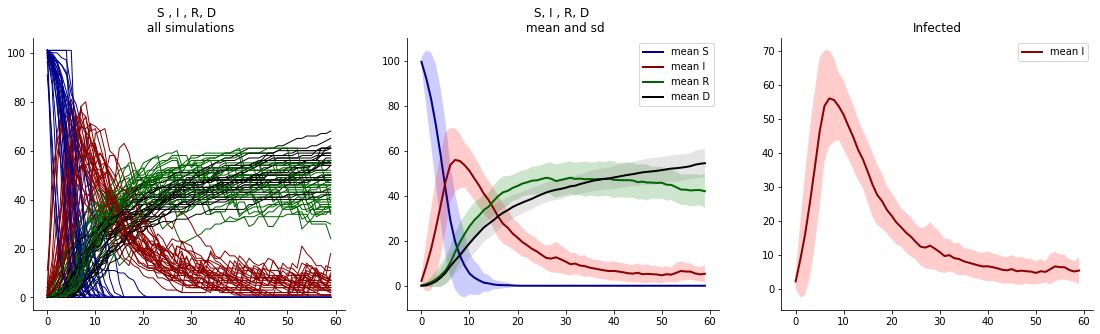

In [66]:
import sys

'''Running the experiments'''


fixed_params = {'num_nodes':num_nodes, 'avg_node_degree':avg_node_degree, 'initial_outbreak_size':1
                , 'virus_spread_chance_low':beta*1.8, 'virus_spread_chance_high':beta*0.8, 'recovery_chance': gamma, 'mortality_rate': mu}

variable_params = {}

batch_run = BatchRunner(
    VirusOnNetwork,  
    variable_params, 
    fixed_params, 
    iterations=30, 
    max_steps=60, 
    model_reporters={"Data Collector": lambda m: m.datacollector.get_model_vars_dataframe()}) 
# Run the experiments
batch_run.run_all()  # this can take a bit

RES = batch_run.get_model_vars_dataframe()

nsim=50
Ss = []
Is= []
Rs = []
Ds = []
for isim in range(RES.shape[0]):
    sys.stdout.write('\rSimulation n°: {}'.format(isim))
    I = RES['Data Collector'][isim].Infected
    S = RES['Data Collector'][isim].Susceptibles
    R = RES['Data Collector'][isim].Recovered
    D = RES['Data Collector'][isim].Dead
    
    Ss.append(S)
    Is.append(I)
    Rs.append(R)
    Ds.append(D)
print('\nDone!') 

'''
Compute mean and sd of our simulations
'''
meanS = np.mean(Ss, axis=0)
meanI = np.mean(Is, axis=0)
meanR = np.mean(Rs, axis=0)
meanD = np.mean(Ds, axis=0)

sdS = np.std(Ss, axis=0, dtype=np.float64)
sdI = np.std(Is, axis=0, dtype=np.float64)
sdR = np.std(Rs, axis=0, dtype=np.float64)
sdD = np.std(Ds, axis=0, dtype=np.float64)

'''
Some Plots
'''
t = np.arange(0, len(meanS), 1)
fig, axs = plt.subplots(1,3, facecolor='w', figsize=(19,5))

axs[0].set_title('S , I , R, D \n all simulations')
for  S, I,R,D in zip(Ss, Is, Rs,Ds):
    axs[0].plot(t, S, c = 'darkblue', lw=1)
    axs[0].plot(t, I, c = 'darkred', lw=1)
    axs[0].plot(t, R, c = 'darkgreen', lw=1)
    axs[0].plot(t, D, c = 'black', lw=1)
    


axs[1].set_title('S, I , R, D \n mean and sd')
axs[1].plot(t, meanS, c = 'darkblue', lw=2, label = 'mean S')
axs[1].plot(t, meanI, c = 'darkred', lw=2, label = 'mean I')
axs[1].plot(t, meanR, c = 'darkgreen', lw=2, label = 'mean R')
axs[1].plot(t, meanD, c = 'black', lw=2, label = 'mean D')
axs[1].fill_between(t, meanS+sdS, meanS-sdS, facecolor='blue', alpha=0.2)
axs[1].fill_between(t, meanI+sdI, meanI-sdI, facecolor='r', alpha=0.2)
axs[1].fill_between(t, meanR+sdR, meanR-sdR, facecolor='g', alpha=0.2)
axs[1].fill_between(t, meanD+sdD, meanD-sdD, facecolor='gray', alpha=0.2)
axs[1].legend(fancybox = True)


axs[2].set_title('Infected')
axs[2].plot(t, meanI, c = 'darkred', lw=2, label = 'mean I')
axs[2].fill_between(t, meanI+sdI, meanI-sdI, facecolor='r', alpha=0.2)
axs[2].legend(fancybox = True)
    
for i in range(3):
    #axs[i].legend(fancybox = True)
    for spine in ('top', 'right'): 
        axs[i].spines[spine].set_visible(False)

In [68]:
I_comm = meanI

## ABM with young sensibilization campaigns <a name="abm_young"></a>

In [69]:

import networkx as nx

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid


import random
import numpy as np
import matplotlib.pyplot as plt

import community
from importlib import reload
import networkx as nx
reload(community)



def compute_S(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Susceptible'])

def compute_I(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Infected'])

def compute_R(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Recovered'])

def compute_D(model):
    return  sum([1 for a in model.schedule.agents if a.state == 'Dead'])

def compute_risk_index(model): #<---  function to compute how many agents have a high risk perception. 
    return  sum([1 for a in model.schedule.agents if a.risk == 'high'])





class VirusOnNetwork(Model):
    """A virus model with some number of agents"""

    def __init__(
        self,
        num_nodes=100,
        avg_node_degree=10,
        initial_outbreak_size=1,
        virus_spread_chance_low=beta*1.8,
        virus_spread_chance_high = beta*0.8,
        recovery_chance=gamma,
        mortality_rate = mu
    ):

        self.num_nodes = num_nodes
        prob = avg_node_degree / (self.num_nodes -1)
        self.G = nx.watts_strogatz_graph(n=self.num_nodes, k = 4, p=prob)
        partition=community.best_partition(self.G)
        #communities = partition.values()
        nx.set_node_attributes(self.G, node_attr)
        comm_df = pd.DataFrame.from_dict(partition, orient = 'index').rename(columns = {0: 'comm'})
        comm_attr = comm_df.to_dict('index')
        
        leaders = []
        for i in comm_df['comm'].unique():
            leaders.append(random.choice(comm_df[comm_df['comm']==i].index))
            
        
        
        nx.set_node_attributes(self.G, comm_attr)
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)
        self.initial_outbreak_size = (
            initial_outbreak_size if initial_outbreak_size <= num_nodes else num_nodes
        )
        self.virus_spread_chance_low = virus_spread_chance_low
        self.virus_spread_chance_high = virus_spread_chance_high
        self.recovery_chance = recovery_chance
        self.mortality_rate = mortality_rate

     #   self.datacollector = DataCollector(
     #       {
     #           "Infected": compute_I,
     #           "Susceptible": compute_S,
     #           "Resistant": compute_R
     #       }
     #   )

    
    
        # DEFINING DIFFERENT CLASSIFIERS, DEPENDING ON THE GLOBAL LEVEL OF INFECTED
        
        
        
        
        # INITIALIZATION OF OUR POPULATION:
        # Create agents
        for i, node in enumerate(self.G.nodes()):
            a = VirusAgent(
                i,
                self,
                initial_state='Susceptible',

                #risk = 'high' if self.G.node[node]['beloved_sick'] == 1 else 'low'

                Age = self.G.nodes[node]['Age'],
                Gender = self.G.nodes[node]['Gender'],
                Disease = self.G.nodes[node]['Disease'],
                Safety = self.G.nodes[node]['Safety'],
                #Current_mood = self.G.nodes[node]['Current_mood'],
                Beloved_sick = self.G.nodes[node]['Beloved_sick'],
                Economic_impact = self.G.nodes[node]['Economic_impact'],
                Individual_risk = self.G.nodes[node]['Individual_risk'],
                Exposed_environment = self.G.nodes[node]['Exposed_environment'],
                Easily_influenced = self.G.nodes[node]['Easily_influenced'],
                #Feeling = self.G.nodes[node]['Feeling'],
                Avg_contacts = self.G.nodes[node]['Avg_contacts'],
                Beloved_care = self.G.nodes[node]['Beloved_care'],
                Hypocondriac = self.G.nodes[node]['Hypocondriac'],

                

                comm = partition.get(node),
                is_leader = 1 if i in leaders else 0,
                risk = self.G.nodes[node]['risk']
                #risk = to_binary(gbm.predict([[self.G.node[node]['Age'],self.G.node[node]['Gender'],
                #                        self.G.node[node]['Disease'], self.G.node[node]['Safety'],
                #                        self.G.node[node]['Beloved_sick'], self.G.node[node]['Economic_impact'], 
                #                        self.G.node[node]['Individual_risk'],self.G.node[node]['Exposed_environment'],
                #                        self.G.node[node]['Easily_influenced'],self.G.node[node]['Avg_contacts'],
                #                        self.G.node[node]['Beloved_care'],self.G.node[node]['Hypocondriac']]])[0])
            )
            
            
            self.schedule.add(a)
            # Add the agent to the node
            self.grid.place_agent(a, node)
            

        # Infect some nodes
        infected_nodes = self.random.sample(self.G.nodes(), self.initial_outbreak_size)
        for a in self.grid.get_cell_list_contents(infected_nodes):
            a.state = 'Infected'

        self.running = True
        self.datacollector = DataCollector(
            model_reporters={"Infected": compute_I,
                             "Susceptibles": compute_S,
                             "Recovered": compute_R, 
                             "Dead": compute_D,
                             "Risk index": compute_risk_index},
            agent_reporters = {"Risk_perception": 'risk', "Leadership":'is_leader', 'comm': 'comm'})
        #self.datacollector = DataCollector(
        #    agent_reporters={"Risk_perception": "risk"}
        #)
        
        #if the agent is a leader, let's spread the message

    def new_outbreak(self):
        infected_nodes = self.random.sample(self.G.nodes(), 15)
        for a in self.grid.get_cell_list_contents(infected_nodes):
            if not a.state == 'Dead':
                a.state = 'Infected'

        
        
        

 

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)
        if random.random()<0.1:
            self.new_outbreak()



class VirusAgent(Agent):
    def __init__(
        self,
        unique_id,
        model,
        initial_state,
        Age,
        Gender,
        Disease,
        Safety,
        #Current_mood,
        Beloved_sick,
        Economic_impact,
        Individual_risk,
        Exposed_environment,
        Easily_influenced,
        #Feeling,
        Avg_contacts,
        Beloved_care,
        Hypocondriac,
        comm,
        is_leader,
        risk):
        super().__init__(unique_id, model)
        

        self.state = initial_state
        self.Age = Age
        self.Gender = Gender
        self.Disease = Disease
        self.Safety = Safety
        #self.Current_mood = Current_mood
        self.Beloved_sick = Beloved_sick
        self.Economic_impact = Economic_impact
        self.Individual_risk = Individual_risk
        self.Exposed_environment = Exposed_environment
        self.Easily_influenced = Easily_influenced
        #self.Feeling = Feeling
        self.Avg_contacts = Avg_contacts
        self.Beloved_care = Beloved_care
        self.Hypocondriac = Hypocondriac   
        self.comm = comm
        self.is_leader = is_leader
        self.risk = risk


    def try_to_infect_neighbors(self):
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if agent.state == 'Susceptible'
        ]
        
        
        global_infected = sum([1 for a in model.schedule.agents if a.state == 'Infected'])
        if global_infected/self.model.num_nodes<0.1:
            gb_clf = gbm_reduce_risk
        elif global_infected/self.model.num_nodes<0.5:
            gb_clf = gbm
        else:
            gb_clf = gbm_rise_risk
        
        #those who have a low risk perception, will have stupid behaviors. I will use a constant of proportionality
        #to increase their chance to be infected
        for a in susceptible_neighbors:
            if a.risk=='low':
                if self.random.random() < self.model.virus_spread_chance_low:
                    a.state = 'Infected'
                    for b in [x for x in self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(a.unique_id))]:
                        b.Beloved_sick = 1
                        b.risk = to_binary(gb_clf.predict([[b.Age,b.Gender, b.Disease, b.Safety, b.Beloved_sick,b.Economic_impact,
                                                  b.Individual_risk, b.Exposed_environment, b.Easily_influenced,
                                                  b.Avg_contacts, b.Beloved_care, b.Hypocondriac]])[0])
                        #self.model.G.node[node]['beloved_sick'] = 1
                        #self.model.G.node[node]['risk'] = str(clf.predict([[self.model.G.node[node]['beloved_sick'],self.model.G.node[node]['disease']]]))
            elif a.risk == 'high':
                if self.random.random() < self.model.virus_spread_chance_high:
                    a.state = 'Infected'
                    for b in [x for x in self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(a.unique_id))]:
                        b.Beloved_sick = 1
                        b.risk = to_binary(gb_clf.predict([[b.Age,b.Gender, b.Disease, b.Safety, b.Beloved_sick,b.Economic_impact,
                                                  b.Individual_risk, b.Exposed_environment, b.Easily_influenced,
                                                  b.Avg_contacts, b.Beloved_care, b.Hypocondriac]])[0])
                    #for node in self.model.grid.get_neighbors(a.unique_id):
                        #self.model.G.node[node]['beloved_sick'] = 1
                        #self.model.G.node[node]['risk'] = str(clf.predict([[self.model.G.node[node]['beloved_sick'],self.model.G.node[node]['disease']]]))
                



    def try_remove_infection(self):
        # Try to remove
        if self.random.random() < self.model.recovery_chance:
            # Success
            self.state = 'Recovered'
            
    def pass_away(self):
        if self.random.random() < self.model.mortality_rate:
            self.state = 'Dead'
            
    def spread_message(self):
        comm_nodes = [node for node in self.model.G.nodes if self.model.G.nodes[node]['comm'] == self.comm]
        influenced_nodes = random.sample(comm_nodes, int(0.314*len(comm_nodes)))
        for agent in self.model.grid.get_cell_list_contents(influenced_nodes):
            agent.risk = 'high'
            for neigh in [x for x in self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(agent.unique_id))]:
                if neigh.Easily_influenced == 1:
                    neigh.risk = 'high'
            
    def get_young_message(self):
        features = random.sample(['Individual_risk', 'Beloved_care'], random.randint(1,2))
        if 'Individual_risk' in features:
            self.my_risk = 1
        if 'Beloved_care' in features:
            self.think_at_beloved = 1
            
        global_infected = sum([1 for a in model.schedule.agents if a.state == 'Infected'])
        if global_infected/self.model.num_nodes<0.3:
            gb_clf = gbm_reduce_risk
        elif global_infected/self.model.num_nodes<0.6:
            gb_clf = gbm
        else:
            gb_clf = gbm_rise_risk
            
        self.risk = to_binary(gb_clf.predict([[self.Age,self.Gender, self.Disease, self.Safety, self.Beloved_sick,self.Economic_impact,
                                                  self.Individual_risk, self.Exposed_environment, self.Easily_influenced,
                                                  self.Avg_contacts, self.Beloved_care, self.Hypocondriac]])[0])
        
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        for agent in self.model.grid.get_cell_list_contents(neighbors_nodes):
            if agent.Easily_influenced == 1 or agent.Beloved_care==1:
                agent.risk = 'high'

    def relax(self):
        gb_clf = gbm_reduce_risk
        self.Individual_risk=0
        self.Safety=1
        self.risk = to_binary(gb_clf.predict([[self.Age,self.Gender, self.Disease, self.Safety, self.Beloved_sick,self.Economic_impact,
                                                  self.Individual_risk, self.Exposed_environment, self.Easily_influenced,
                                                  self.Avg_contacts, self.Beloved_care, self.Hypocondriac]])[0])
        

    def step(self):
        if self.state == 'Infected':
            self.try_to_infect_neighbors()
            self.try_remove_infection()
            self.pass_away()
                        
        #if self.is_leader:
        #    self.spread_message()
            
        if self.Age<30:
            self.get_young_message()

        if sum([1 for a in model.schedule.agents if a.state == 'Infected'])/self.model.num_nodes<0.2 and self.Disease==0:
            self.relax()




In [ ]:
beta = 0.316
d = 14
gamma = 1/14


model = VirusOnNetwork(num_nodes, avg_node_degree,15, beta*1.8,beta*0.8, gamma, mu)
while model.running and model.schedule.steps < 100:
    model.step()
print(model.schedule.steps)

# PLOT
RES = model.datacollector.get_model_vars_dataframe()
fig, axs = plt.subplots(nrows=1, ncols=2, facecolor='w', figsize=(17,5))
fig.suptitle('Model with young target sensibilization campaign', fontsize=14)

ax = axs[0]
ax.set_title('SIDR dynamics')
ax.plot(RES.index, RES.Susceptibles, 'b', alpha=0.9, lw=2.5, label= 'Susceptibles')
ax.plot(RES.index, RES.Infected, 'r', alpha=0.9, lw=2.5, label= 'Infected')
ax.plot(RES.index, RES.Recovered, 'g', alpha=0.9, lw=2.5, label= 'Recovered')
ax.plot(RES.index, RES.Dead, 'black', alpha=0.9, lw=2.5, label= 'Dead')
ax.set_xlabel('Time')
ax.set_ylabel('S,I,R')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)

for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)

ax = axs[1]
ax.set_title('Phase graph')
ax.scatter(RES.Susceptibles, RES.Infected ,s=2, facecolor='k')

ax.set_xlabel('S')
ax.set_ylabel('I')


for spine in ('top', 'right'): 
    ax.spines[spine].set_visible(False)

#I_young = RES.Infected

30it [01:08,  2.29s/it]


Simulation n°: 29
Done!


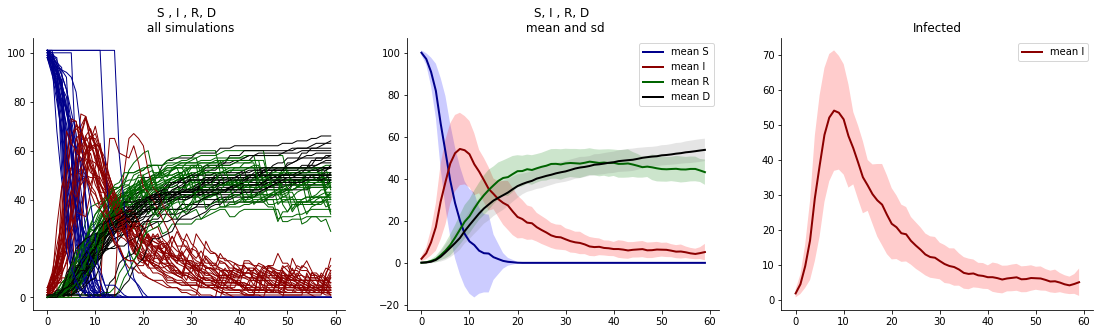

In [70]:
import sys

'''Running the experiments'''


fixed_params = {'num_nodes':num_nodes, 'avg_node_degree':avg_node_degree, 'initial_outbreak_size':1
                , 'virus_spread_chance_low':beta*1.8, 'virus_spread_chance_high':beta*0.8, 'recovery_chance': gamma, 'mortality_rate': mu}

variable_params = {}

batch_run = BatchRunner(
    VirusOnNetwork,  
    variable_params, 
    fixed_params, 
    iterations=30, 
    max_steps=60, 
    model_reporters={"Data Collector": lambda m: m.datacollector.get_model_vars_dataframe()}) 
# Run the experiments
batch_run.run_all()  # this can take a bit

RES = batch_run.get_model_vars_dataframe()

nsim=50
Ss = []
Is= []
Rs = []
Ds = []
for isim in range(RES.shape[0]):
    sys.stdout.write('\rSimulation n°: {}'.format(isim))
    I = RES['Data Collector'][isim].Infected
    S = RES['Data Collector'][isim].Susceptibles
    R = RES['Data Collector'][isim].Recovered
    D = RES['Data Collector'][isim].Dead
    
    Ss.append(S)
    Is.append(I)
    Rs.append(R)
    Ds.append(D)
print('\nDone!') 

'''
Compute mean and sd of our simulations
'''
meanS = np.mean(Ss, axis=0)
meanI = np.mean(Is, axis=0)
meanR = np.mean(Rs, axis=0)
meanD = np.mean(Ds, axis=0)

sdS = np.std(Ss, axis=0, dtype=np.float64)
sdI = np.std(Is, axis=0, dtype=np.float64)
sdR = np.std(Rs, axis=0, dtype=np.float64)
sdD = np.std(Ds, axis=0, dtype=np.float64)

'''
Some Plots
'''
t = np.arange(0, len(meanS), 1)
fig, axs = plt.subplots(1,3, facecolor='w', figsize=(19,5))

axs[0].set_title('S , I , R, D \n all simulations')
for  S, I,R,D in zip(Ss, Is, Rs,Ds):
    axs[0].plot(t, S, c = 'darkblue', lw=1)
    axs[0].plot(t, I, c = 'darkred', lw=1)
    axs[0].plot(t, R, c = 'darkgreen', lw=1)
    axs[0].plot(t, D, c = 'black', lw=1)
    


axs[1].set_title('S, I , R, D \n mean and sd')
axs[1].plot(t, meanS, c = 'darkblue', lw=2, label = 'mean S')
axs[1].plot(t, meanI, c = 'darkred', lw=2, label = 'mean I')
axs[1].plot(t, meanR, c = 'darkgreen', lw=2, label = 'mean R')
axs[1].plot(t, meanD, c = 'black', lw=2, label = 'mean D')
axs[1].fill_between(t, meanS+sdS, meanS-sdS, facecolor='blue', alpha=0.2)
axs[1].fill_between(t, meanI+sdI, meanI-sdI, facecolor='r', alpha=0.2)
axs[1].fill_between(t, meanR+sdR, meanR-sdR, facecolor='g', alpha=0.2)
axs[1].fill_between(t, meanD+sdD, meanD-sdD, facecolor='gray', alpha=0.2)
axs[1].legend(fancybox = True)


axs[2].set_title('Infected')
axs[2].plot(t, meanI, c = 'darkred', lw=2, label = 'mean I')
axs[2].fill_between(t, meanI+sdI, meanI-sdI, facecolor='r', alpha=0.2)
axs[2].legend(fancybox = True)
    
for i in range(3):
    #axs[i].legend(fancybox = True)
    for spine in ('top', 'right'): 
        axs[i].spines[spine].set_visible(False)
        


In [71]:
I_young = meanI

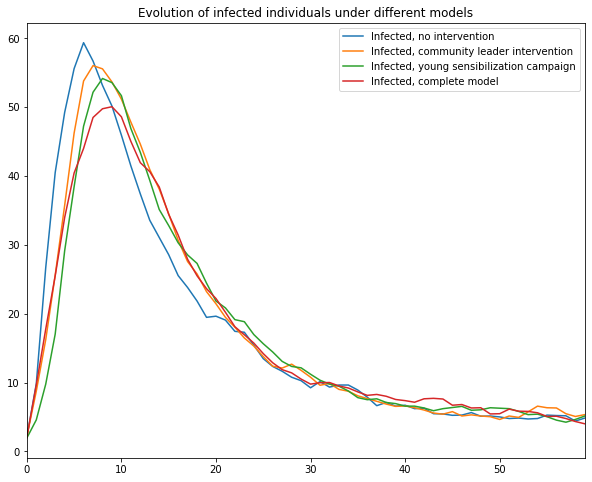

In [81]:
frame = { 'I_basic': I_basic, 'I_comm': I_comm, 'I_young': I_young, 'I_complete': I_complete } 
  
I_result = pd.DataFrame(frame)

fig= plt.figure(figsize=(10,8))
I_result.I_basic.plot(label = 'Infected, no intervention')
I_result.I_comm.plot(label = 'Infected, community leader intervention')
I_result.I_young.plot(label = 'Infected, young sensibilization campaign')
I_result.I_complete.plot(label = 'Infected, complete model')
plt.title('Evolution of infected individuals under different models')
plt.legend()

As you can see, the highest peak of infected individuals is reached with the simulation under the model with no interventions. On the other hand, the complete model (including both young sensibilization campaigns and community leaders messages spreading) lead to a peak of around 10 individuals less, which, considering the initial population, is about the 10%.